In [3]:
import datetime

from src.logger import LoggerConfig

LoggerConfig.setup_logger()

ANALYSIS_START_DATE = datetime.date.fromisoformat("2014-09-17")
ANALYSIS_END_DATE = datetime.date.fromisoformat("2025-04-27")

2025-04-28 21:49:58,659 - root - INFO - Logger configured


In [4]:
from src.data_sources.google_trends import GoogleTrendsDataSource
google_trends_data = GoogleTrendsDataSource.load(
    from_date=ANALYSIS_START_DATE,
    to_date=ANALYSIS_END_DATE,
    keywords=[
        'bitcoin', 'btc', 'ethereum', 'eth', 'crypto',
        'buy bitcoin', 'sell bitcoin', 'bitcoin price', 'crypto trading', 'crypto price',
        'crypto crash', 'bitcoin crash', 'crypto fear', 'crypto bull run', 'crypto bear market',
        'gold', 'usd', 'usdt', 'usdc',
        'web3', 'nft', 'defi', 'blockchain',
        'binance', 'coinbase', 'crypto.com', 'kraken', 'okx',
        'bitcoin investment', 'how to buy bitcoin', 'bitcoin price',
        'war', 'conflict', 'ETF',
    ]
)
google_trends_data

2025-04-28 21:50:00,012 - root - INFO - Загружаем данные из API
2025-04-28 21:50:00,344 - root - INFO - Собираем тренды для: ['bitcoin', 'btc', 'ethereum', 'eth', 'crypto']


TooManyRequestsError: The request failed: Google returned a response with code 429

In [136]:
from src.data_sources.prices import PricesDataSource
prices_data = PricesDataSource.load(
    from_date=ANALYSIS_START_DATE,
    to_date=ANALYSIS_END_DATE,
    interval="1d",
    tickers=[
        'BTC-USD',
        'ETH-USD',
        'SOL-USD',
        'BNB-USD',
        'ADA-USD',
        'SPY',  # индекс акций
        'GLD',  # золото
    ]
)
prices_data[['date', 'btc_usd_close']]

,date,btc_usd_close
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014
...,...,...
3870,2025-04-22,93441.890625
3871,2025-04-23,93699.109375
3872,2025-04-24,93943.796875
3873,2025-04-25,94720.500000


In [143]:
import pandas as pd
import numpy as np
import ta  # если не установлено: pip install ta

# --- 1. Препроцессинг PRICES данных ---
prices = prices_data.copy()
prices['date'] = pd.to_datetime(prices['date'])
prices = prices.sort_values('date')
prices['weekday'] = prices['date'].dt.weekday
prices['is_weekend'] = prices['weekday'].isin([5, 6]).astype(int)
prices['month'] = pd.to_datetime(prices['date']).dt.month

# # --- 2. Препроцессинг Google Trends ---
# trends = google_trends_data.copy()
# trends['date'] = pd.to_datetime(trends['date'])
# trends = trends.sort_values('date')
#
# # Заполняем отсутствующие даты "последним известным значением"
# full_dates = pd.DataFrame({'date': pd.date_range(prices['date'].min(), prices['date'].max(), freq='D')})
# trends = pd.merge(full_dates, trends, on='date', how='left')
# trends[['crypto', 'bitcoin']] = trends[['crypto', 'bitcoin']].ffill().bfill()
#
# # --- 3. Объединение данных ---
# df = pd.merge(prices, trends, on='date', how='left')
df = prices.copy()

# --- 4. Генерация технических индикаторов ---
OHLCV = ['open', 'close', 'high', 'low', 'volume']
for col in df.columns:
    for price_type in OHLCV:
        if not col.endswith(price_type):
            continue

        ticker_base = col.replace(f"_{price_type}", "")

        if price_type == 'close':
            # 4.1 Скользящие средние
            df[ticker_base+'_ma_5'] = df[ticker_base+'_close'].rolling(window=5, min_periods=1).mean()
            df[ticker_base+'_ma_10'] = df[ticker_base+'_close'].rolling(window=10, min_periods=1).mean()

            # 4.2 Индикатор RSI
            rsi_indicator = ta.momentum.RSIIndicator(close=df[ticker_base+'_close'], window=6)
            df[ticker_base+'_rsi_6'] = rsi_indicator.rsi()
            rsi_indicator = ta.momentum.RSIIndicator(close=df[ticker_base+'_close'], window=12)
            df[ticker_base+'_rsi_12'] = rsi_indicator.rsi()
            rsi_indicator = ta.momentum.RSIIndicator(close=df[ticker_base+'_close'], window=24)
            df[ticker_base+'_rsi_24'] = rsi_indicator.rsi()

            # 4.3 Волатильность
            df[ticker_base+'_volatility_6'] = df[ticker_base+'_close'].rolling(window=6, min_periods=1).std()
            df[ticker_base+'_volatility_12'] = df[ticker_base+'_close'].rolling(window=12, min_periods=1).std()
            df[ticker_base+'_volatility_24'] = df[ticker_base+'_close'].rolling(window=24, min_periods=1).std()

            # 4.4 Процентное изменение цены
            df[ticker_base+'_price_change_1d'] = df[ticker_base+'_close'].pct_change(periods=1)
            df[ticker_base+'_price_change_7d'] = df[ticker_base+'_close'].pct_change(periods=7)
            df[ticker_base+'_price_change_30d'] = df[ticker_base+'_close'].pct_change(periods=30)

            # 4.5 MACD
            df[ticker_base+'_macd_line'] = df[ticker_base+'_close'].ewm(span=12, adjust=False).mean() - df[ticker_base+'_close'].ewm(span=26, adjust=False).mean()
            df[ticker_base+'_macd_signal'] = df[ticker_base+'_macd_line'].ewm(span=9, adjust=False).mean()

        if price_type == 'high':
            df[ticker_base+'_price_high_low_diff'] = df[ticker_base+'_high'] - df[ticker_base+'_low']

        if price_type == 'open':
            df[ticker_base+'_price_open_close_diff'] = df[ticker_base+'_open'] - df[ticker_base+'_close']

# important_features = [col for col in df.columns if ('close' in col or 'volume' in col or 'rsi' in col or 'macd' in col)]
# lags = [1, 7, 30]  # только короткие лаги
# for feature in important_features:
#     for lag in lags:
#         df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)

# --- 5. Создание целевых переменных (target'ов) ---
df['target_1d'] = (df['btc_usd_close'].shift(-1) - df['btc_usd_close']) / df['btc_usd_close']
df['target_7d'] = (df['btc_usd_close'].shift(-7) - df['btc_usd_close']) / df['btc_usd_close']
df['target_30d'] = (df['btc_usd_close'].shift(-30) - df['btc_usd_close']) / df['btc_usd_close']

# --- 7. Финальная подготовка ---
# Убираем строки с пустыми значениями
df = df.dropna(subset=['target_1d', 'target_7d', 'target_30d'])

# --- 8. Отделяем фичи и таргеты ---
# Теперь все колонки кроме target-ов и даты — это признаки
target_columns = ['target_1d', 'target_7d', 'target_30d']
exclude_columns = ['date', 'target_1d', 'target_7d', 'target_30d']
feature_columns = [col for col in df.columns if col not in exclude_columns]

real_data = df.sort_values('date', ascending=False)
real_data = real_data[['date', 'target_1d', 'btc_usd_close']]

features = df[feature_columns]
targets = df[target_columns]


C:\Users\nurla\AppData\Local\Temp\ipykernel_21204\2875063539.py:55: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df[ticker_base+'_price_change_1d'] = df[ticker_base+'_close'].pct_change(periods=1)
C:\Users\nurla\AppData\Local\Temp\ipykernel_21204\2875063539.py:56: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df[ticker_base+'_price_change_7d'] = df[ticker_base+'_close'].pct_change(periods=7)
C:\Users\nurla\AppData\Local\Temp\ipykernel_21204\2875063539.py:57: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in an

In [144]:
real_data

,date,target_1d,btc_usd_close
3844,2025-03-27,-0.032393,87177.101562
3843,2025-03-26,0.003179,86900.882812
3842,2025-03-25,-0.006526,87471.703125
3841,2025-03-24,-0.000311,87498.914062
3840,2025-03-23,0.016786,86054.375000
...,...,...,...
4,2014-09-21,0.008352,398.821014
3,2014-09-20,-0.024659,408.903992
2,2014-09-19,0.035735,394.795990
1,2014-09-18,-0.069843,424.440002


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60712
[LightGBM] [Info] Number of data points in the train set: 3768, number of used features: 241
[LightGBM] [Info] Start training from score 0.002076
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

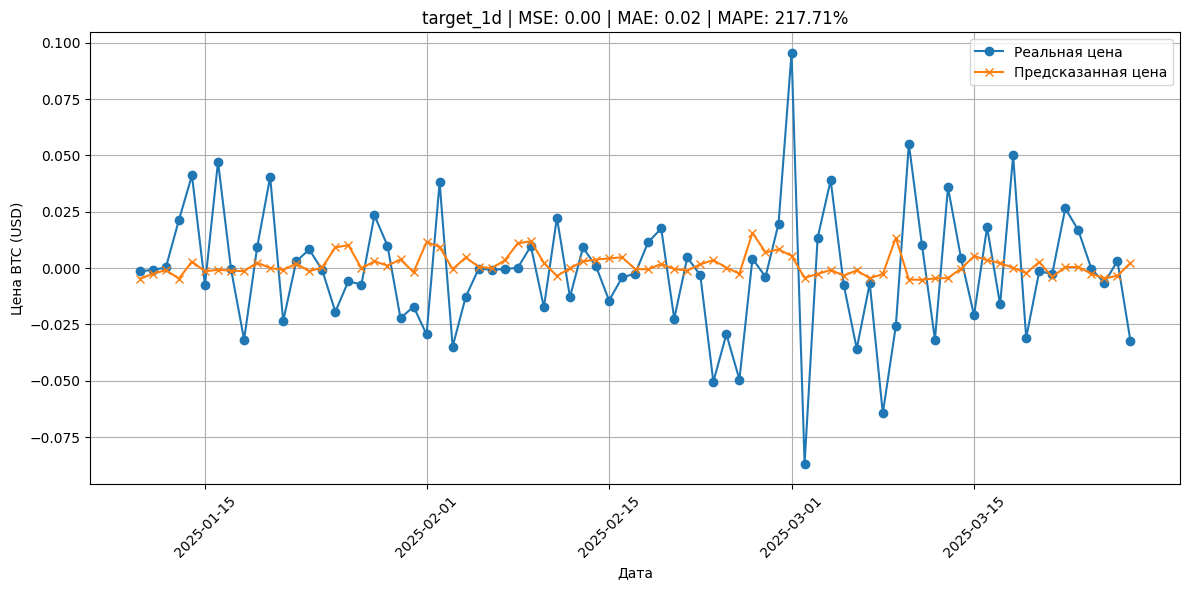

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60712
[LightGBM] [Info] Number of data points in the train set: 3768, number of used features: 241
[LightGBM] [Info] Start training from score 0.014925
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

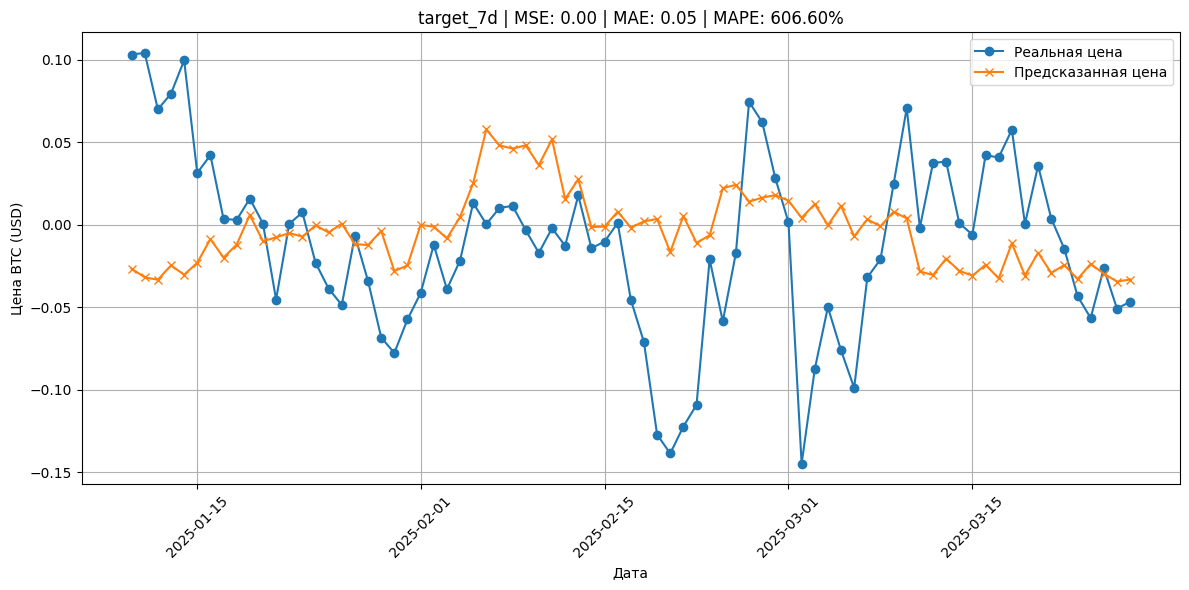

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60712
[LightGBM] [Info] Number of data points in the train set: 3768, number of used features: 241
[LightGBM] [Info] Start training from score 0.069635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

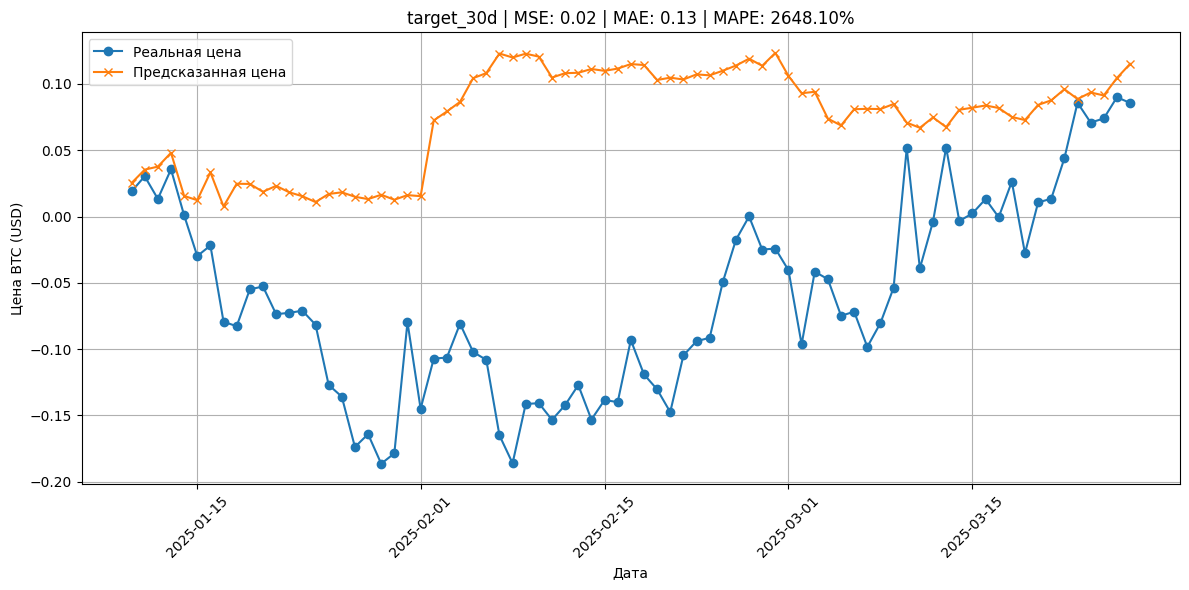

In [146]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

models = {}
mse_scores = {}
mape_scores = {}

# 1. Разделяем данные
X = features.copy()
y = targets.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, shuffle=False)

# 2. Для каждой цели обучаем свою модель
for target_name in y.columns:
    model = LGBMRegressor(
        n_estimators=400,
        max_depth=8,
        min_child_samples=40,
        learning_rate=0.01,
        colsample_bytree=0.7,  # recommended 0.7
        subsample=0.8,  # recommended 0.8
        reg_alpha=0.5,
        reg_lambda=0.5,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train[target_name])

    y_pred = model.predict(X_test)
    y_pred_price = X_test['btc_usd_close'].values * (1 + y_pred)

    mse = mean_squared_error(y_test[target_name], y_pred)
    mae = mean_absolute_error(y_test[target_name], y_pred)
    mape = np.mean(np.abs((y_test[target_name] - y_pred) / y_test[target_name])) * 100
    models[target_name] = model
    mse_scores[target_name] = mse
    mape_scores[target_name] = mape

    # 3. Строим график для каждой цели
    plt.figure(figsize=(12, 6))
    x_dates = df.loc[y_test.index, 'date']

    plt.plot(x_dates, y_test[target_name].values, label="Реальная цена", marker='o')
    plt.plot(x_dates, y_pred, label="Предсказанная цена", marker='x')
    plt.title(f"{target_name} | MSE: {mse:.2f} | MAE: {mae:.2f} | MAPE: {mape:.2f}%")
    plt.xlabel("Дата")
    plt.ylabel("Цена BTC (USD)")
    plt.legend()
    plt.grid(True)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

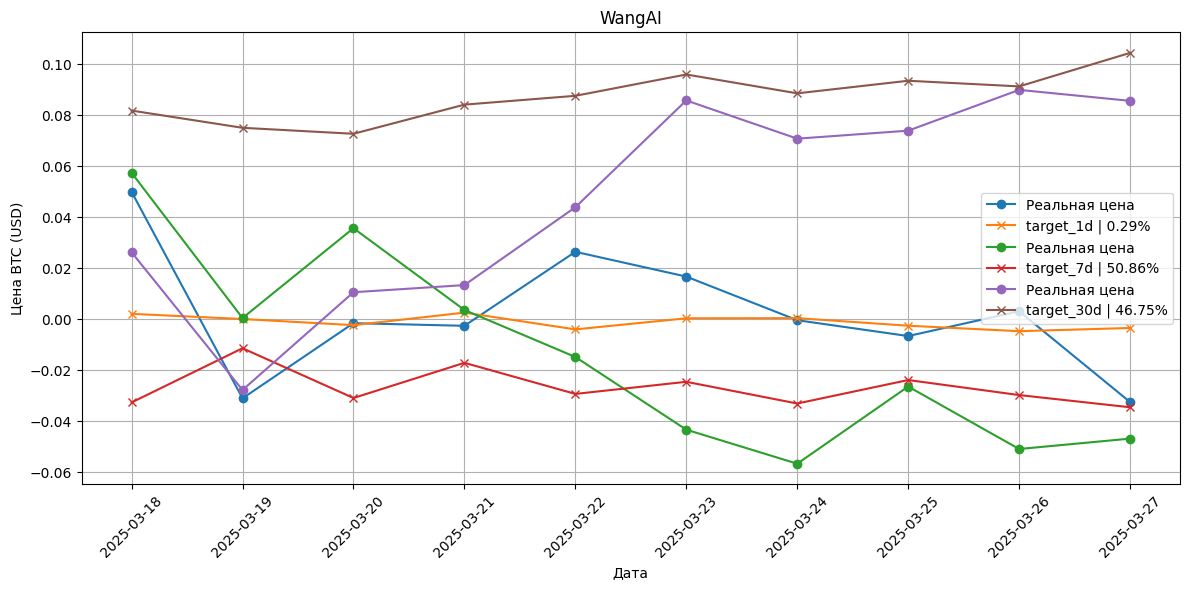

In [154]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np


def predict_price(model_name: str, latest_features) -> float:
    return models[model_name].predict(latest_features)[0]

def predict(model_: str):
    days_to_predict = 10
    real_price_changes = []
    predicted_price_changes = []
    dates = []

    for i in range(-days_to_predict, 0):
        real_price_change = float(targets.iloc[i][model_])
        predicted_price_change = predict_price(model_, features.iloc[[i-1]])
        real_price_changes.append(real_price_change)
        predicted_price_changes.append(predicted_price_change)
        dates.append(df.iloc[targets.index[i]]['date'])

    # --- Симуляция торговли на основе предсказаний ---
    my_budget = 1000
    other_budget = 1000
    for real, pred in zip(real_price_changes, predicted_price_changes):
        if pred < 0:
            pred = -pred
        profit = my_budget * pred
        my_budget += profit

        profit = other_budget * real
        other_budget += profit

    total_return_percent = ((my_budget - other_budget) / other_budget) * 100

    # --- Строим график ---
    plt.plot(dates, real_price_changes, label="Реальная цена", marker='o')
    plt.plot(dates, predicted_price_changes, label=f"{model_} | {total_return_percent:.2f}%", marker='x')

plt.figure(figsize=(12, 6))
for target_name in y.columns:
    predict(target_name)


plt.title(f"WangAI")
plt.xlabel("Дата")
plt.ylabel("Цена BTC (USD)")
plt.legend()
plt.grid(True)

# Оформление дат
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [120]:
latest_features = features.iloc[[-1]]
for target_name in y.columns:
    predict = models[target_name].predict(latest_features)[0]
    print(target_name, predict)
real_data['target_1d']

target_1d 0.0006709816665930522
target_7d -0.10456369381465999
target_30d -0.07662587899744003


3874    0.000777
3873   -0.008200
3872   -0.002605
3871   -0.002745
3870   -0.063387
          ...   
34     -0.009393
33      0.017503
32      0.004867
31     -0.019630
30     -0.003132
Name: target_1d, Length: 3845, dtype: float64

In [68]:
latest_features

,sol_usd_open,sol_usd_high,sol_usd_low,sol_usd_close,sol_usd_adj_close,sol_usd_volume,gld_open,gld_high,gld_low,gld_close,...,eth_usd_adj_rsi_12,eth_usd_adj_rsi_24,eth_usd_adj_volatility_6,eth_usd_adj_volatility_12,eth_usd_adj_volatility_24,eth_usd_adj_price_change_1d,eth_usd_adj_price_change_7d,eth_usd_adj_price_change_30d,eth_usd_adj_macd_line,eth_usd_adj_macd_signal
3843,143.817078,145.368484,136.136353,137.288574,137.288574,3.083071e+09,278.929993,279.019989,277.779999,278.23999,...,44.839376,41.27999,45.86407,60.321148,115.405982,-0.028328,-0.023598,-0.200743,-87.880813,-127.228037


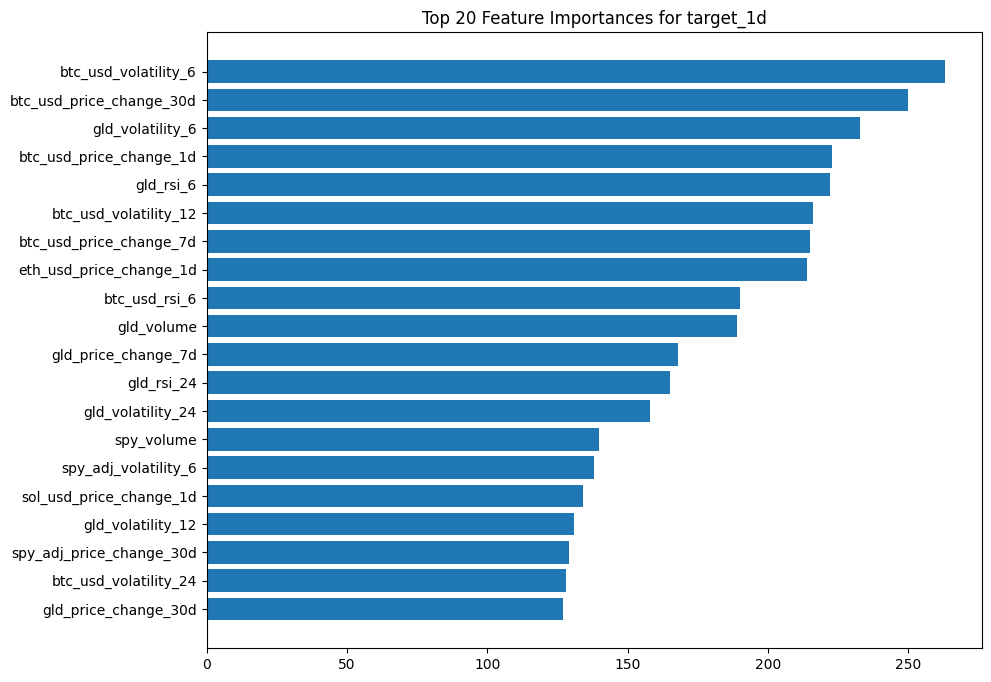

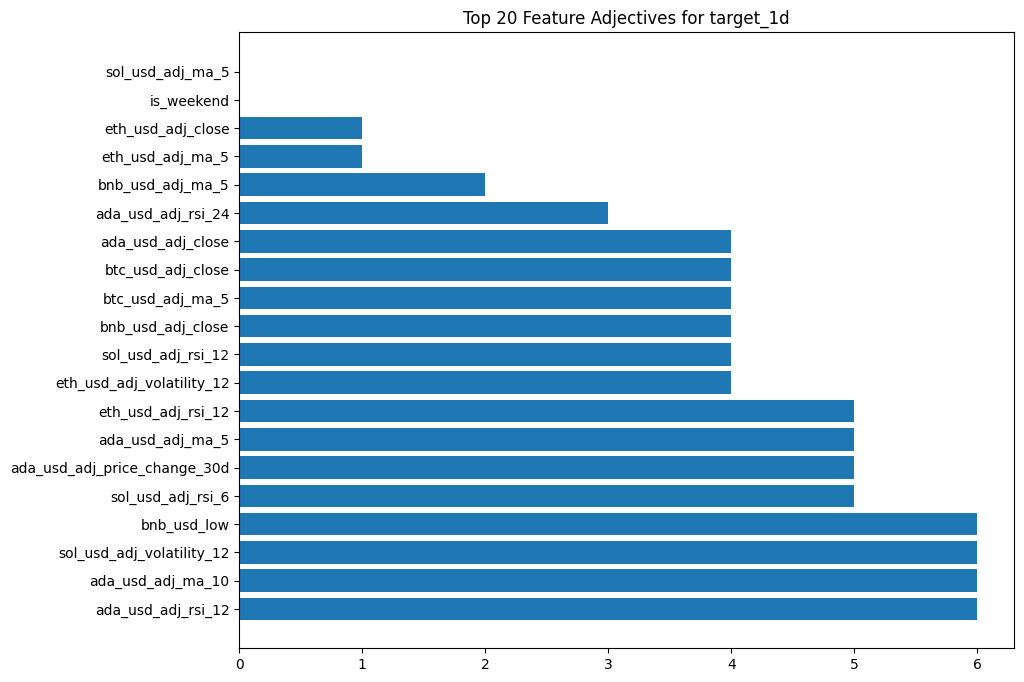

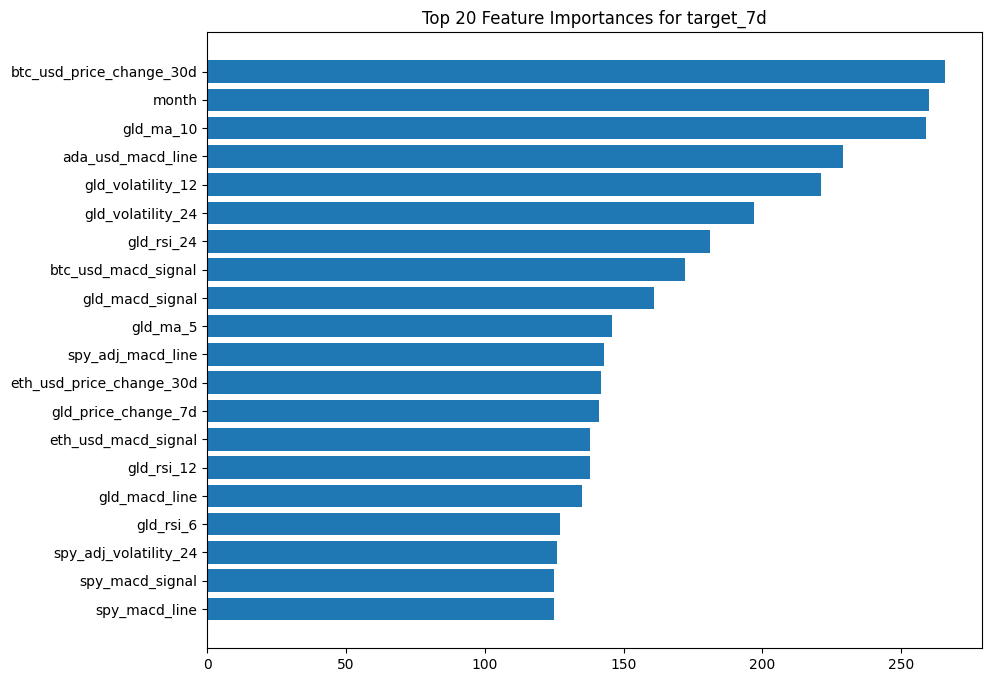

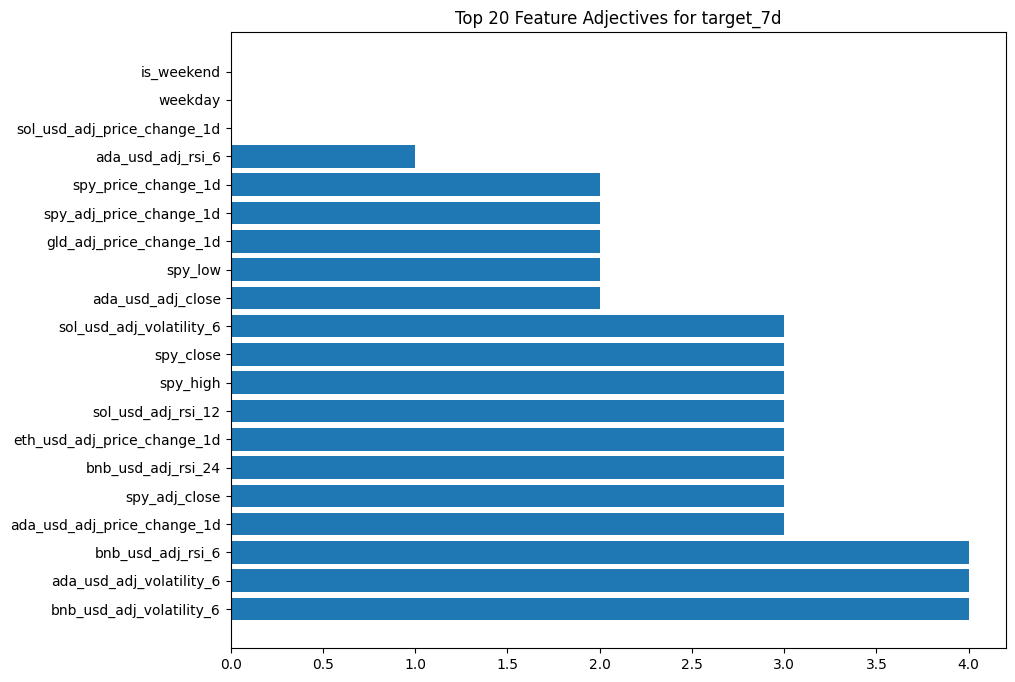

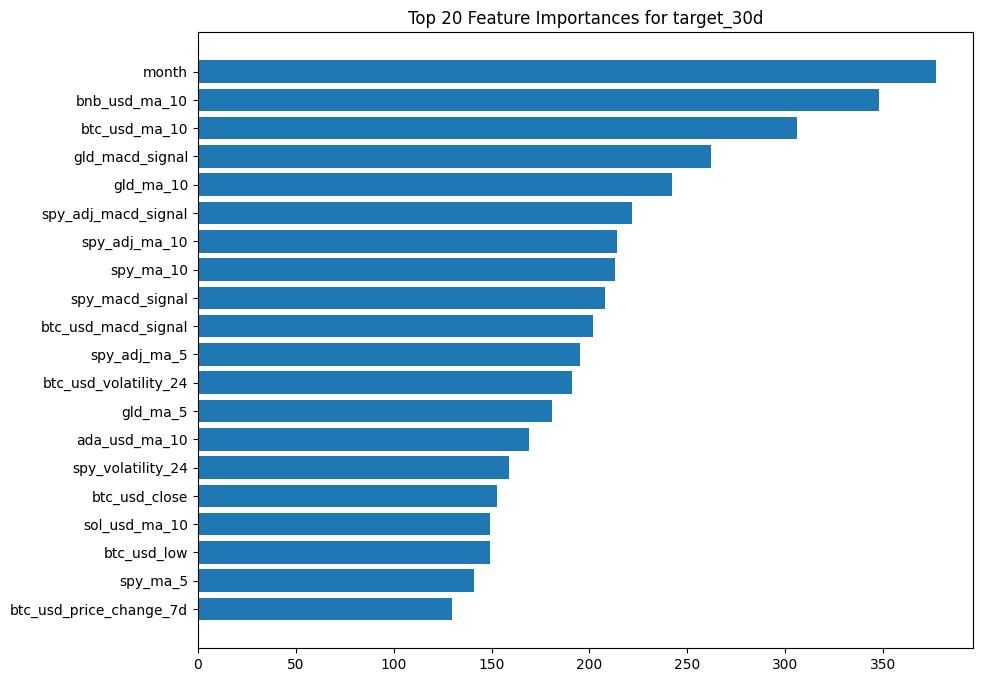

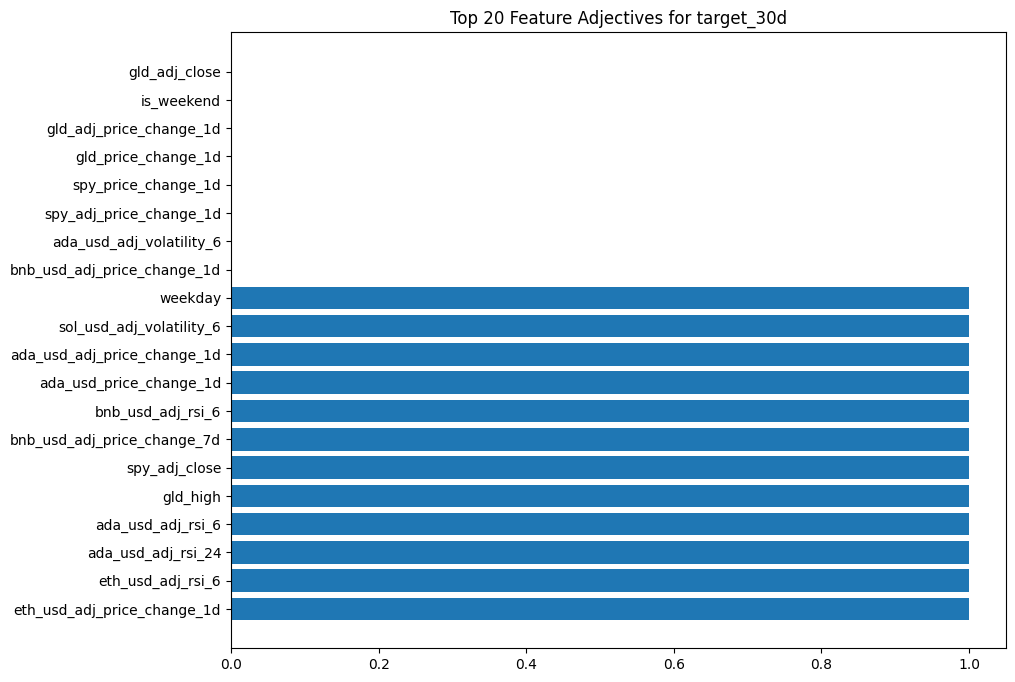

In [91]:
import matplotlib.pyplot as plt

def plt_show(df_: pd.DataFrame, model_name_: str, *, adjective: bool = False):
    plt.figure(figsize=(10, 8))
    plt.barh(df_['feature'][:20], df_['importance'][:20])
    plt.gca().invert_yaxis()
    if adjective:
        plt.title(f"Top 20 Feature Adjectives for {model_name_}")
    else:
        plt.title(f"Top 20 Feature Importances for {model_name_}")
    plt.show()

def show_importances(model_: str):
    importances = models[model_].feature_importances_
    features_list = features.columns

    # В DataFrame
    features_df = pd.DataFrame({'feature': features_list, 'importance': importances})
    importance_df = features_df.sort_values('importance', ascending=False)
    adjectives_df  = features_df.sort_values('importance', ascending=True)

    # Построить график
    plt_show(importance_df, model_)
    plt_show(adjectives_df, model_, adjective=True)


show_importances('target_1d')
show_importances('target_7d')
show_importances('target_30d')
